In [16]:
import os
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, save_img
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [19]:
# Step 1: Define the dataset path (update this to your local directory)
data_directory = r'E:\DATA SETS\Plant Disease Juipter'

# Check if the directory exists
if os.path.exists(data_directory):
    print(f"Dataset directory found: {data_directory}")
else:
    raise FileNotFoundError("Dataset directory not found. Please check the path.")

# Data augmentation for training, focusing on 'healthy' class balancing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3,
    horizontal_flip=True,         # Random horizontal flips
    vertical_flip=True,           # Random vertical flips
    zoom_range=0.2,               # Random zoom
    brightness_range=[0.5, 1.5],  # Random brightness adjustments
    fill_mode='nearest'           # Fill empty pixels with nearest neighbors
)

# Generators for training and validation
train_generator = train_datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

validation_generator = train_datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

# Test generator without augmentation
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,
)

test_generator = test_datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

Dataset directory found: E:\DATA SETS\Plant Disease Juipter
Found 23527 images belonging to 28 classes.
Found 10066 images belonging to 28 classes.
Found 3349 images belonging to 28 classes.


In [20]:
# Step 4: Build the Model with Transfer Learning
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(28, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
# Step 5: Train the Model
EPOCHS = 50
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
   #callbacks=[early_stopping, lr_scheduler],
)
# Evaluate the model on validation and test sets
val_loss, val_accuracy = model.evaluate(validation_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50


E:\3uTools\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


368/368 ━━━━━━━━━━━━━━━━━━━━ 1845s 5s/step - accuracy: 0.4437 - loss: 1.9618 - val_accuracy: 0.8377 - val_loss: 0.5098
Epoch 2/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1093s 3s/step - accuracy: 0.7543 - loss: 0.7560 - val_accuracy: 0.8767 - val_loss: 0.3982
Epoch 3/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1074s 3s/step - accuracy: 0.7865 - loss: 0.6473 - val_accuracy: 0.8916 - val_loss: 0.3397
Epoch 4/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1073s 3s/step - accuracy: 0.8016 - loss: 0.5899 - val_accuracy: 0.8925 - val_loss: 0.3358
Epoch 5/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1070s 3s/step - accuracy: 0.8153 - loss: 0.5455 - val_accuracy: 0.8936 - val_loss: 0.3217
Epoch 6/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1073s 3s/step - accuracy: 0.8194 - loss: 0.5367 - val_accuracy: 0.8991 - val_loss: 0.3165
Epoch 7/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1075s 3s/step - accuracy: 0.8296 - loss: 0.5061 - val_accuracy: 0.8969 - val_loss: 0.3012
Epoch 8/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1075s 3s/step - accuracy: 0.8269 - loss: 0.5037 - val_accurac

In [22]:
#  Predictions and Metrics Calculation
# Get predictions from the validation generator
validation_generator.reset()  # Reset generator to start from the beginning
predictions = model.predict(validation_generator)    # Generates predictions for validation set
predicted_classes = np.argmax(predictions, axis=1)   # Converts probabilities to class labels

# True classes from the generator
true_classes = validation_generator.classes         # Actual labels from validation set
class_labels = list(validation_generator.class_indices.keys())  # Gets class names

158/158 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step


In [23]:
#  Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.95      0.89      0.92       189
                            Apple___Black_rot       0.94      0.97      0.96       186
                     Apple___Cedar_apple_rust       0.98      0.96      0.97        82
                              Apple___healthy       0.96      0.98      0.97       493
                           Corn___Common_Rust       0.99      0.99      0.99       357
                        Corn___Gray_Leaf_Spot       0.80      0.69      0.74       153
                  Corn___Northern_Leaf_Blight       0.83      0.91      0.87       295
                                 Corn_healthy       0.99      0.99      0.99       348
                        Potato___Early_blight       0.98      0.97      0.97       300
                         Potato___Late_blight       0.95      0.92      0.94       300
                   

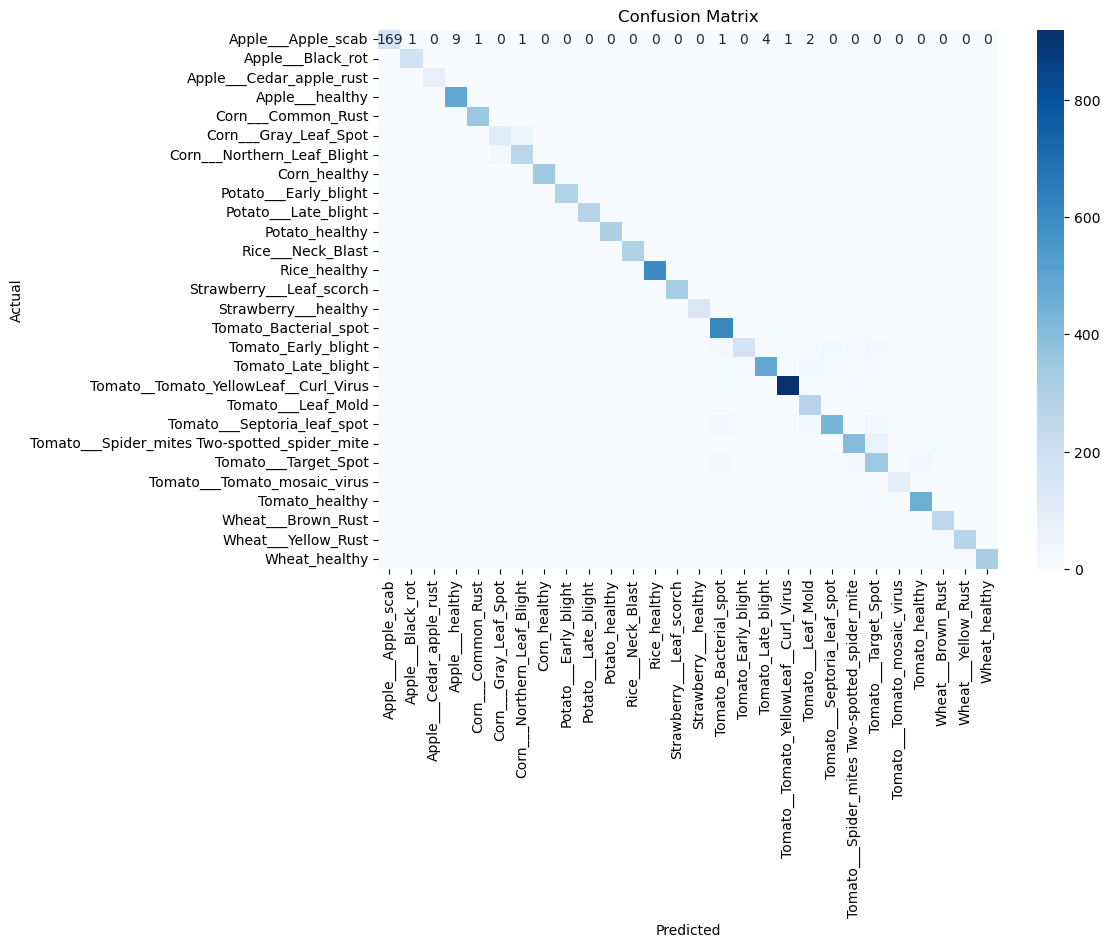

In [24]:
#  Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

F1 Score: 0.9161


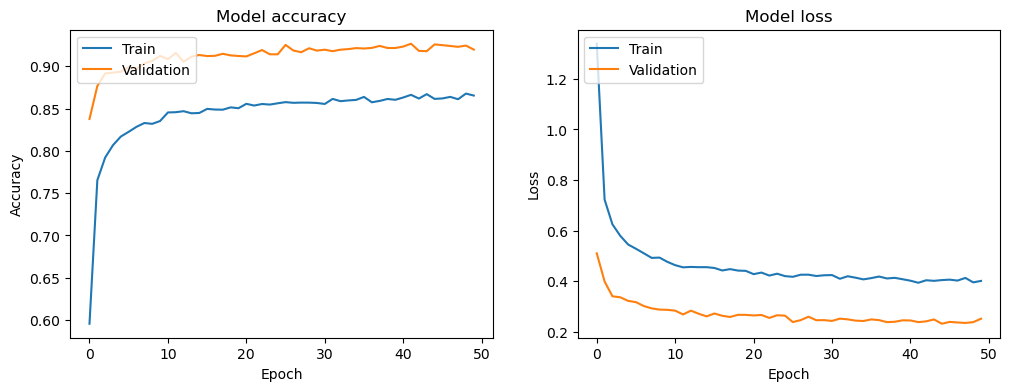

In [25]:
#  Additional Metrics
from sklearn.metrics import f1_score

f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

#  plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


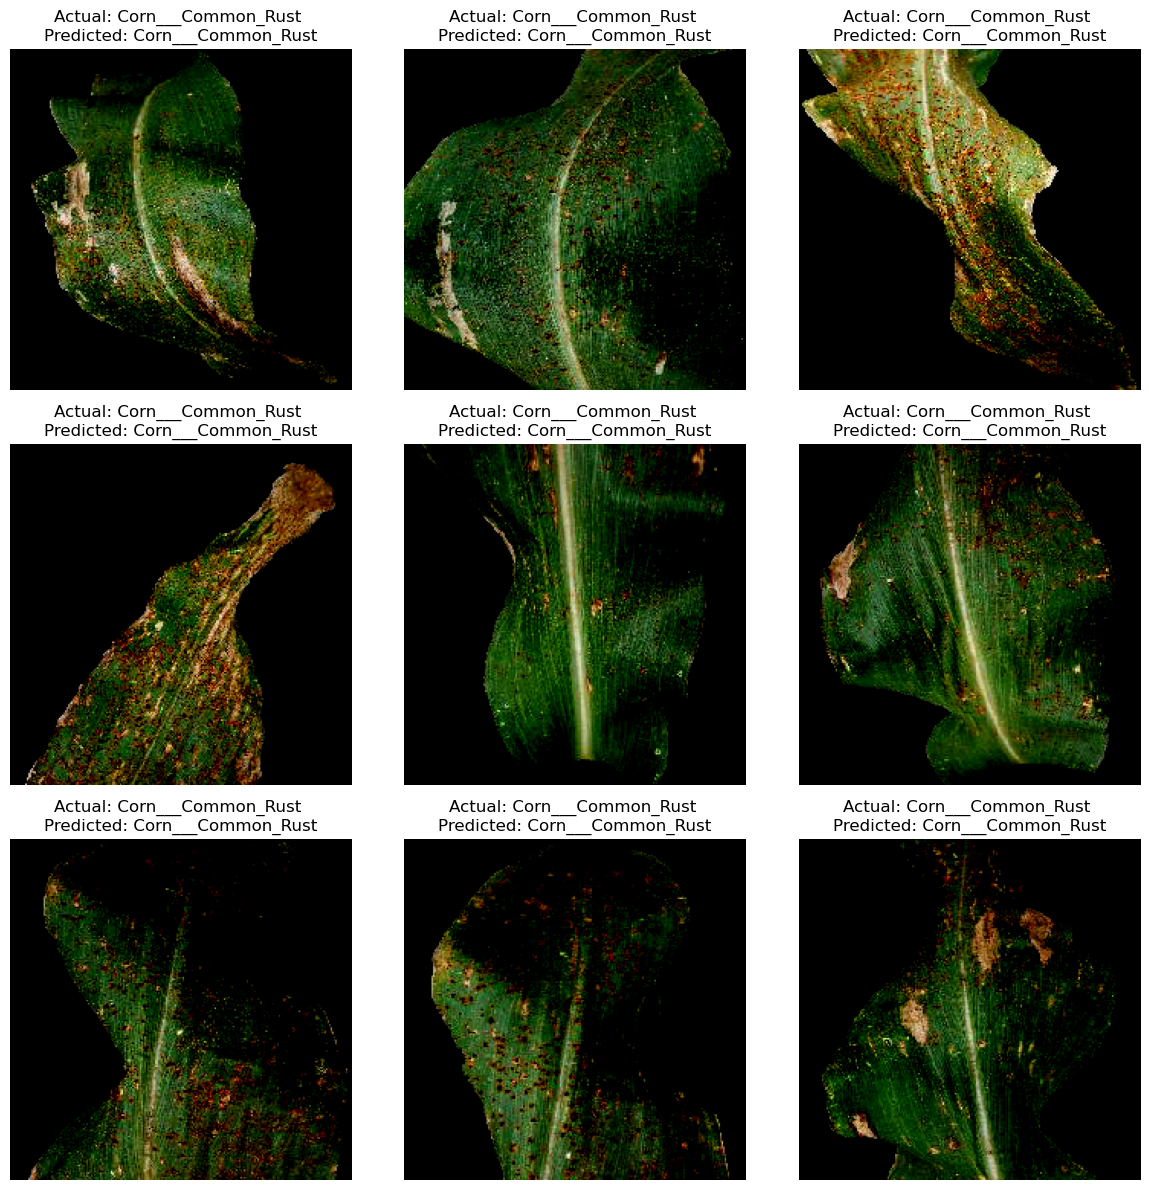

In [9]:
# Reset the test generator to start from the beginning
test_generator.reset()  # Resets the generator for consistent test results

# Step 1: Get predictions and actual labels
predictions = model.predict(test_generator)               # Predictions for test data
predicted_classes = np.argmax(predictions, axis=1)        # Maps probabilities to predicted labels
true_classes = test_generator.classes                     # Actual labels from test set
class_labels = list(test_generator.class_indices.keys())  # List of class labels

# Step 2: Select a batch of test images for displaying
batch = next(test_generator)  # Gets the next batch of images and labels
images, labels = batch[0], batch[1]  # Separates images and their true labels

# Step 3: Plot images with actual and predicted labels
plt.figure(figsize=(12, 12))       # Sets up the plot figure size
for i in range(9):                 # Display first 9 images
    ax = plt.subplot(3, 3, i + 1)  # Arrange images in a 3x3 grid
    image = images[i]
    true_label = class_labels[np.argmax(labels[i])]       # Get true class label for each image
    predicted_label = class_labels[predicted_classes[i]]  # Predicted class label

    plt.imshow(image)  # Display the image
    plt.title(f"Actual: {true_label} \nPredicted: {predicted_label}")  # Shows true vs predicted label
    plt.axis("off")  # Hides axes

plt.tight_layout()  # Adjusts layout to avoid overlap
plt.show()  # Display the plot

In [27]:
model.save(r'E:\DATA SETS\Model 92% 28class\Model.h5')

In [29]:
model.save(r'E:\DATA SETS\Model 92% 28class\Model.keras')